In [1]:
from SimPEG import (
    maps, utils, data, optimization, maps, regularization, 
    inverse_problem, directives, inversion, data_misfit
)
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as nsem
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
#from pymatsolver import Pardiso as Solver
from pymatsolver import Solver

from matplotlib.colors import LogNorm
from ipywidgets import interact, widgets
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

(25, 3)


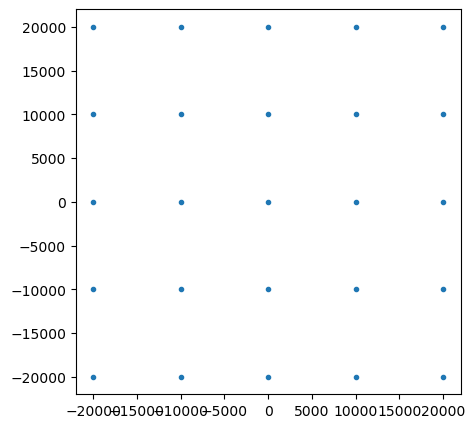

In [2]:
frequencies = np.array([0.01,0.1, 1])
periods = 1/frequencies
#periods = np.logspace(-3,3,20)
#frequencies = 1/periods
station_spacing = 10000
factor_spacing = 4
rx_x, rx_y = np.meshgrid(np.arange(-20000, 20001, station_spacing), np.arange(-20000, 20001, station_spacing))
rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))
#rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), mkvc(rx_x/5+rx_y/8+10000, 2)))


print(rx_loc.shape)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
ax.set_aspect(1)

In [3]:
periods

array([100.,  10.,   1.])

# Malla

In [4]:
from discretize import TensorMesh
from discretize.utils import active_from_xyz
from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from scipy.interpolate import Rbf

def make_example_mesh():
    dh = 5000.0 # Tamaño de celda inicial
    #hx = [(dh, 5, -1.1), (dh, 20), (dh, 5, 1.1)]
    #hy = [(dh, 5, -1.1), (dh, 20), (dh, 5, 1.1)]
    #hz = [(dh, 5, -1.1), (dh, 20), (dh, 5, 1.1)]

    # Mallado de 41x41
    hx = [(dh, 10.0)]
    hy = [(dh, 10.0)]
    hz = [(dh, 10.0)]

    mesh2 = TensorMesh([hx, hy, hz], "CCC")

    return mesh2

mesh2 = make_example_mesh()

halfspace_value = 100.0

# Definir la topografía
#[xx, yy] = np.meshgrid(mesh2.nodes_x, mesh2.nodes_y)
#zz = xx/5+yy/8+ 10000
#topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Find cells below topography and define mapping
air_value = 0.0
ind_active = mesh2.gridCC[:, 2] < 0.0

#ind_active = active_from_xyz(mesh2, topo, "N")
model_map = maps.InjectActiveCells(mesh2, ind_active, air_value)

# Define the model
model = halfspace_value * np.ones(ind_active.sum())

In [6]:
halfspace_value = np.ones(mesh2.nC) * 1e-8
#ind_active = mesh.cell_centers[:,2] < 0.
halfspace_value[ind_active] = 1e-2

model_copy = model.copy()
sigma=halfspace_value.copy()

In [7]:
## create target blocks
ind_block_1 = utils.model_builder.getIndicesBlock([5000, -15000, -5000], [15000, 15000, -15000], mesh2.gridCC)[0].tolist()
ind_block_2 = utils.model_builder.getIndicesBlock([-15000, -15000, -5000], [5000, -5000, -15000], mesh2.gridCC)[0].tolist()

model_copy[ind_block_1] = 1
model_copy[ind_block_2] = 1

sigma[ind_block_1] = 1
sigma[ind_block_2] = 1



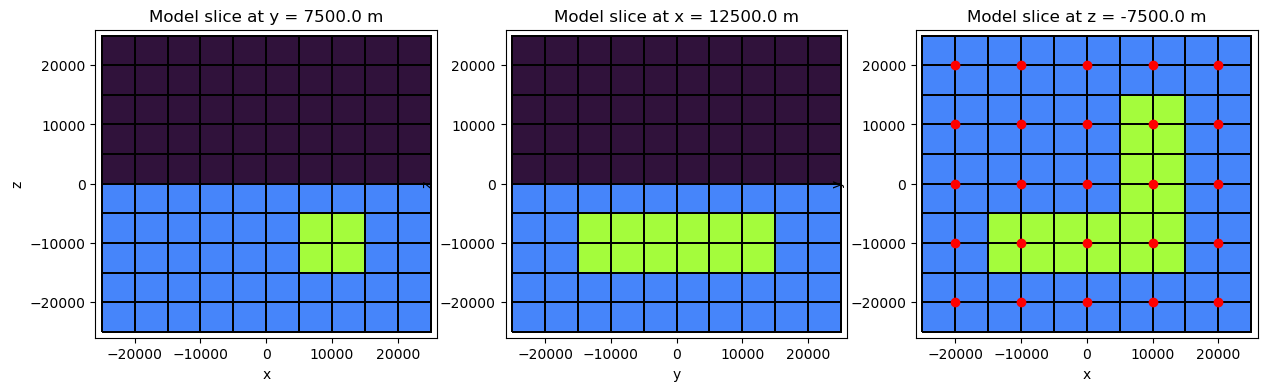

In [8]:
# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
#ind_slice = int(mesh2.shape_cells[1] / 2)

ind_slice = 6
mesh2.plot_slice(sigma, normal="Y", ax=ax, ind=ind_slice, grid=True,
                    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1e+3)},
                    grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700)
                 )
ax.set_title("Model slice at y = {} m".format(mesh2.cell_centers_y[ind_slice]))
ax.set_ylim(-26000, 26000)
ax.set_xlim(-26000, 26000)


ax = fig.add_subplot(132)
# 0 a 42
ind_slice = 7

mesh2.plot_slice(sigma, normal="X", ax=ax, ind=ind_slice, grid=True,
                pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1e+3)},
                grid_opts={"lw":0.1, "color":'k'}, 
                 #range_x=(rx_loc[:,1].min() - 500, rx_loc[:,1].max() + 500)
                 )
ax.set_title("Model slice at x = {} m".format(mesh2.cell_centers_x[ind_slice]))
ax.set_ylim(-26000, 26000)
ax.set_xlim(-26000, 26000)

#2-24
ind_slice = 3 
ax = fig.add_subplot(133)
#ind_slice = int(mesh2.shape_cells[1] / 2)
mesh2.plot_slice(sigma, 
                normal="Z", 
                ax=ax, 
                ind=ind_slice, 
                grid=True,
                pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1e+3)},
                grid_opts={"lw":0.1, "color":'k'}, 
                #range_x=(rx_loc[:,0].min() - 700, rx_loc[:,0].max() + 700), 
                #range_y=(rx_loc[:,1].min() - 700, rx_loc[:,1].max() + 700)
                )
ax.set_ylim(-26000, 26000)
ax.set_xlim(-26000, 26000)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')

ax.set_title("Model slice at z = {} m".format(mesh2.cell_centers_z[ind_slice]))
plt.show()

In [9]:
print(f"Number of cells: {mesh2.n_cells}")

Number of cells: 1000


# Datos Sintéticos

In [10]:
# Generate a Survey
rx_list = []
rx_orientations_impedance = ['xx', 'xy', 'yx', 'yy']
for rx_orientation in rx_orientations_impedance:    
    rx_list.append(     
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
rx_orientations_tipper = ['zx', 'zy']
for rx_orientation in rx_orientations_tipper:    
    rx_list.append(     
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
# Source list
src_list = [nsem.sources.PlanewaveXYPrimary(rx_list, frequency=f) for f in frequencies]

# Survey MT
survey = nsem.Survey(src_list)

In [11]:
for rx in rx_list:
    print(rx.orientation, rx.component)

xx real
xx imag
xy real
xy imag
yx real
yx imag
yy real
yy imag
zx real
zx imag
zy real
zy imag


In [12]:
rx_orientations = rx_orientations_impedance + rx_orientations_tipper

In [29]:
%%time
# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=mesh2, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh2) * active_map

# True model 
m_true = np.log(halfspace_value[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary(
    mesh=mesh2,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=halfspace_value,
    solver=Solver

)
dpred = simulation.dpred(m_true)

CPU times: total: 719 ms
Wall time: 2.92 s


In [28]:
dpred

array([-5.03451959e-21, -5.64243665e-22, -2.30536477e-31,  5.64243665e-22,
        5.03451959e-21, -1.64199044e-21, -5.06837771e-22, -5.17944312e-31,
        5.06837770e-22,  1.64199044e-21, -3.74071448e-30, -2.79126404e-31,
        5.04060352e-31,  8.26767004e-31,  2.52823237e-31,  1.64199044e-21,
        5.06837771e-22, -3.09777361e-31, -5.06837771e-22, -1.64199044e-21,
        5.03451959e-21,  5.64243666e-22, -8.50610795e-33, -5.64243665e-22,
       -5.03451959e-21, -2.05817840e-20, -1.82178847e-21,  1.72693189e-31,
        1.82178847e-21,  2.05817840e-20, -5.33801704e-21, -1.45129737e-21,
        5.31947934e-31,  1.45129737e-21,  5.33801704e-21,  2.86936045e-30,
        4.01087408e-31, -3.52619925e-31, -5.56892146e-31,  5.88736048e-31,
        5.33801704e-21,  1.45129737e-21,  1.37186589e-31, -1.45129737e-21,
       -5.33801704e-21,  2.05817840e-20,  1.82178847e-21,  1.65348906e-31,
       -1.82178847e-21, -2.05817840e-20, -1.98990037e-03, -1.98990037e-03,
       -1.98990037e-03, -

In [26]:
dpred

array([ 2.25416448e-04,  1.20599901e-04, -1.22825831e-04, -1.62088249e-04,
       -1.86704080e-04,  1.38839163e-04,  3.13535159e-05, -2.18861177e-04,
       -5.20238088e-04, -5.99498450e-04,  1.37143517e-05,  1.94737528e-05,
       -2.62276130e-04, -8.97996019e-04, -9.29537081e-04, -1.51510006e-04,
       -5.85773194e-05, -3.73648348e-05, -8.87373319e-05, -2.15300845e-04,
       -2.72178933e-04, -2.65298967e-04,  4.91648487e-06,  2.75717308e-04,
        2.25163801e-04,  1.16428672e-04,  3.54543608e-05, -8.92936028e-05,
       -6.60170807e-05, -6.53567983e-05,  5.06037867e-05, -7.72458114e-06,
       -1.11500563e-04, -2.25646097e-04, -2.37187453e-04, -1.29689473e-05,
       -1.15226395e-05, -1.18572855e-04, -4.20576447e-04, -4.20209691e-04,
       -9.08591015e-05, -4.40013602e-05, -1.94807684e-05, -2.30135096e-05,
       -6.84802304e-05, -1.60768820e-04, -1.66493314e-04, -5.73237685e-06,
        1.63418503e-04,  1.46437386e-04, -1.82445163e-03, -2.12465396e-03,
       -1.91502355e-03, -

In [30]:
relative_error = 0.05
n_rx = rx_loc.shape[0]
n_freq = len(frequencies)
n_component = 2
n_orientation = len(rx_orientations)


DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
DCLEAN = DOBS.copy()

FLOOR = np.zeros_like(DOBS)
FLOOR[:,2,0,:] = np.percentile(abs(DOBS[:,2,0,:].flatten()), 90) * 0.1
FLOOR[:,2,1,:] = np.percentile(abs(DOBS[:,2,1,:].flatten()), 90) * 0.1
FLOOR[:,3,0,:] = np.percentile(abs(DOBS[:,3,0,:].flatten()), 90) * 0.1
FLOOR[:,3,1,:] = np.percentile(abs(DOBS[:,3,1,:].flatten()), 90) * 0.1
FLOOR[:,4,0,:] = np.percentile(abs(DOBS[:,4,0,:].flatten()), 90) * 0.1
FLOOR[:,4,1,:] = np.percentile(abs(DOBS[:,4,1,:].flatten()), 90) * 0.1
FLOOR[:,5,0,:] = np.percentile(abs(DOBS[:,5,0,:].flatten()), 90) * 0.1
FLOOR[:,5,1,:] = np.percentile(abs(DOBS[:,5,1,:].flatten()), 90) * 0.1
STD = abs(DOBS) * relative_error + FLOOR
# STD = (FLOOR)
standard_deviation = STD.flatten()
dobs = DOBS.flatten() 
dobs += abs(dobs) * relative_error * np.random.randn(dobs.size)
DOBS = dobs.reshape((n_freq, n_orientation, n_component, n_rx))
# + standard_deviation * np.random.randn(standard_deviation.size)


In [31]:
components = ['Real', 'Imag']

In [32]:
def foo_data(i_freq, i_orientation, i_component):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DCLEAN[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DCLEAN[i_freq, i_orientation, i_component,:].max()])
    out1 = utils.plot2Ddata(rx_loc, DCLEAN[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax, contourOpts={'cmap':'turbo'}, ncontour=20)
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    if i_orientation<4:
        transfer_type = "Z"
    else:
        transfer_type = "T"
    ax.set_title("Frequency={:.1e}, {:s}{:s}-{:s}".format(frequencies[i_freq], transfer_type, rx_orientations[i_orientation], components[i_component]))

In [33]:
"""interact(
    foo_data,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)"""

'interact(\n    foo_data,\n    i_freq=widgets.IntSlider(min=0, max=n_freq-1),\n    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), \n    i_component=widgets.IntSlider(min=0, max=n_component-1), \n)'

In [34]:
# Assign uncertainties
# make data object
data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)

In [35]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
"""
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy((data_object.standard_deviation), 'k.', ms=1)
plt.show()
"""

"\nplt.semilogy(abs(data_object.dobs), '.r')\nplt.semilogy((data_object.standard_deviation), 'k.', ms=1)\nplt.show()\n"

# Inversión

In [56]:
# Optimization
opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
# Regularization
dz = mesh2.h[2].min()
dx = mesh2.h[0].min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(mesh=mesh2, indActive=ind_active, mapping=regmap)
reg.alpha_s = 1e-5
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=3)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e-1)
# Target misfit stop
target = directives.TargetMisfit()
# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()
directive_list = [beta, beta_est, target, save_dictionary]
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an intitial guess
m_0 = np.log(halfspace_value[ind_active])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DPrimarySecondary problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.30e+55  1.92e+02  0.00e+00  1.92e+02    5.35e+31      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.9346e+01
1 : |xc-x_last| = 0.0000e+00 <= tolX*(1

In [22]:
save_dictionary.outDict

{1: {'iter': 1,
  'beta': 993.3634038872705,
  'phi_d': 64145.9562624477,
  'phi_m': 0.05609472547656728,
  'f': 64670.67319284605,
  'm': array([-4.60517018, -4.60517018, -4.60517019, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517018, -4.60517018, -4.60517018,
         -4.60517017, -4.60517019, -4.60517019, -4.60517019, -4.60517018,
         -4.60517018, -4.60517019, -4.60517019, -4.60517018, -4.60517017,
         -4.60517018, -4.60517019, -4.6051702 , -4.6051702 , -4.60517019,
         -4.60517019, -4.60517019, -4.60517018, -4.60517016, -4.60517014,
         -4.60517019, -4.60517019, -4.6051702 , -4.6051702 , -4.6051702 ,
         -4.6051702 , -4.60517019, -4.60517017, -4.60517015, -4.60517012,
         -4.60517019, -4.6051702 , -4.6051702 , -4.6051702 , -4.6051702 ,
         -4.6051702 , -4.60517019, -4.60517017, -4.60517014, -4.60517012,
         -4.6051702 , -4.6051702 , -4.6051702 , -4.6051702 , -4.6051702 ,
         -4.60517019, -4.60517018, -4.60517016, -

In [23]:
import pickle

# Diccionario que quieres guardar
out_dict = save_dictionary.outDict  # Asumiendo que este es tu diccionario

# Guardar el diccionario en un archivo
with open("DICCIONARIO_INVERSION_PRUEBA.pkl", "wb") as file:
    pickle.dump(out_dict, file)

In [25]:
with open("DICCIONARIO_INVERSION_PRUEBA.pkl", "rb") as file:
    loaded_dict = pickle.load(file)

loaded_dict

{1: {'iter': 1,
  'beta': 993.3634038872705,
  'phi_d': 64145.9562624477,
  'phi_m': 0.05609472547656728,
  'f': 64670.67319284605,
  'm': array([-4.60517018, -4.60517018, -4.60517019, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517018, -4.60517018, -4.60517018,
         -4.60517017, -4.60517019, -4.60517019, -4.60517019, -4.60517018,
         -4.60517018, -4.60517019, -4.60517019, -4.60517018, -4.60517017,
         -4.60517018, -4.60517019, -4.6051702 , -4.6051702 , -4.60517019,
         -4.60517019, -4.60517019, -4.60517018, -4.60517016, -4.60517014,
         -4.60517019, -4.60517019, -4.6051702 , -4.6051702 , -4.6051702 ,
         -4.6051702 , -4.60517019, -4.60517017, -4.60517015, -4.60517012,
         -4.60517019, -4.6051702 , -4.6051702 , -4.6051702 , -4.6051702 ,
         -4.6051702 , -4.60517019, -4.60517017, -4.60517014, -4.60517012,
         -4.6051702 , -4.6051702 , -4.6051702 , -4.6051702 , -4.6051702 ,
         -4.60517019, -4.60517018, -4.60517016, -

# Modelo

In [37]:
target.target

450.0

In [38]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
"""
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(inv_prob.dpred), 'k.', ms=1)
plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()
"""

"\nplt.semilogy(abs(data_object.dobs), '.r')\nplt.semilogy(abs(inv_prob.dpred), 'k.', ms=1)\nplt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)\nplt.show()\n"

In [39]:
iteration = len(save_dictionary.outDict)
m = save_dictionary.outDict[iteration]['m']
sigma_est = mapping*m
pred = save_dictionary.outDict[iteration]['dpred']


In [40]:
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))

In [41]:
DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))

In [42]:
DOBS

array([[[[-5.03451959e-21, -5.64243665e-22, -2.30536477e-31,
           5.64243665e-22,  5.03451959e-21, -1.64199044e-21,
          -5.06837771e-22, -5.17944312e-31,  5.06837770e-22,
           1.64199044e-21, -3.74071448e-30, -2.79126404e-31,
           5.04060352e-31,  8.26767004e-31,  2.52823237e-31,
           1.64199044e-21,  5.06837771e-22, -3.09777361e-31,
          -5.06837771e-22, -1.64199044e-21,  5.03451959e-21,
           5.64243666e-22, -8.50610795e-33, -5.64243665e-22,
          -5.03451959e-21],
         [-2.05817840e-20, -1.82178847e-21,  1.72693189e-31,
           1.82178847e-21,  2.05817840e-20, -5.33801704e-21,
          -1.45129737e-21,  5.31947934e-31,  1.45129737e-21,
           5.33801704e-21,  2.86936045e-30,  4.01087408e-31,
          -3.52619925e-31, -5.56892146e-31,  5.88736048e-31,
           5.33801704e-21,  1.45129737e-21,  1.37186589e-31,
          -1.45129737e-21, -5.33801704e-21,  2.05817840e-20,
           1.82178847e-21,  1.65348906e-31, -1.82178847e-

In [43]:
MISFIT = (DPRED-DOBS)/STD

In [44]:
rx_orientations

['xx', 'xy', 'yx', 'yy', 'zx', 'zy']

In [45]:
n_rx

25

In [46]:
DPRED

array([[[[-5.03451959e-21, -5.64243665e-22, -2.30536477e-31,
           5.64243665e-22,  5.03451959e-21, -1.64199044e-21,
          -5.06837771e-22, -5.17944312e-31,  5.06837770e-22,
           1.64199044e-21, -3.74071448e-30, -2.79126404e-31,
           5.04060352e-31,  8.26767004e-31,  2.52823237e-31,
           1.64199044e-21,  5.06837771e-22, -3.09777361e-31,
          -5.06837771e-22, -1.64199044e-21,  5.03451959e-21,
           5.64243666e-22, -8.50610795e-33, -5.64243665e-22,
          -5.03451959e-21],
         [-2.05817840e-20, -1.82178847e-21,  1.72693189e-31,
           1.82178847e-21,  2.05817840e-20, -5.33801704e-21,
          -1.45129737e-21,  5.31947934e-31,  1.45129737e-21,
           5.33801704e-21,  2.86936045e-30,  4.01087408e-31,
          -3.52619925e-31, -5.56892146e-31,  5.88736048e-31,
           5.33801704e-21,  1.45129737e-21,  1.37186589e-31,
          -1.45129737e-21, -5.33801704e-21,  2.05817840e-20,
           1.82178847e-21,  1.65348906e-31, -1.82178847e-

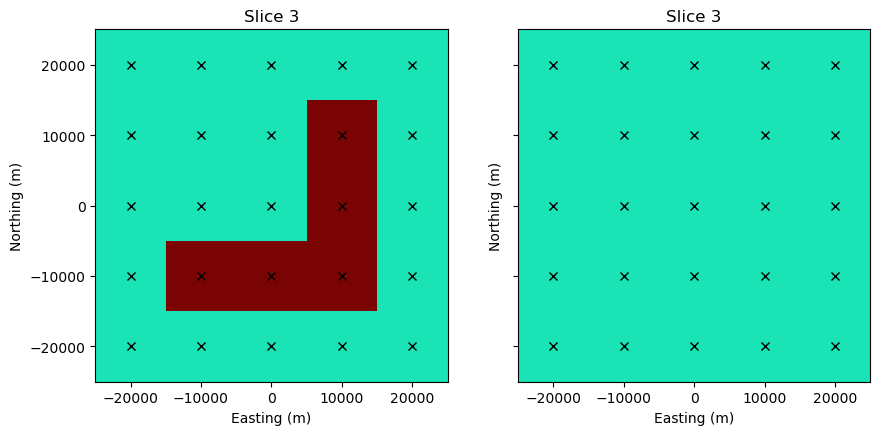

In [47]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
z_loc = -7500.
y_loc = 7500.
x_loc = 12500.
mesh2.plot_slice(
    sigma, grid=False, normal='Z', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
mesh2.plot_slice(
    sigma_est, grid=False, normal='Z', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

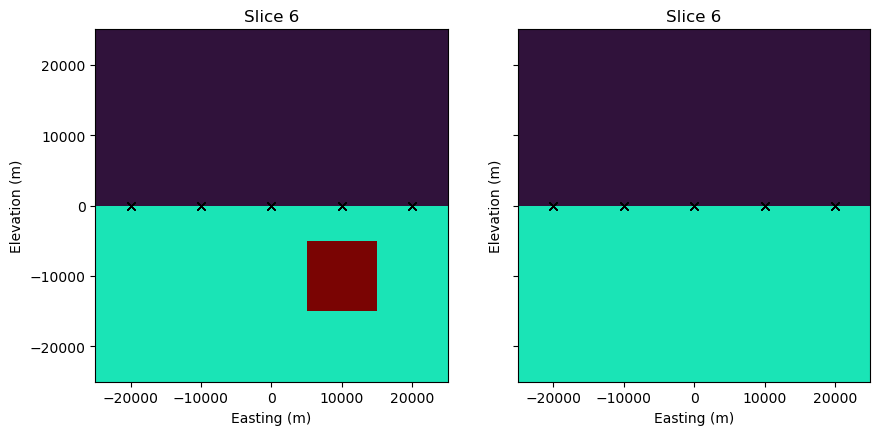

In [48]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
mesh2.plot_slice(
    sigma, grid=False, normal='Y', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #range_y=(-lx_core, lx_core*0.1),
    range_y = (-25000, 25000),
    slice_loc=y_loc
)
mesh2.plot_slice(
    sigma_est, grid=False, normal='Y', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #range_y=(-lx_core, lx_core*0.1),
    range_y = (-25000, 25000),
    slice_loc=y_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")


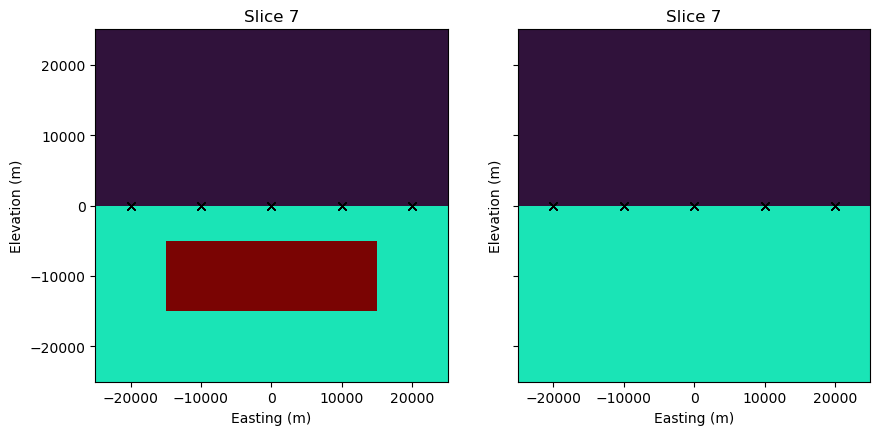

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
mesh2.plot_slice(
    sigma, grid=False, normal='X', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #range_y=(-lx_core, lx_core*0.1),
    range_y = (-25000, 25000),
    slice_loc=x_loc
)
mesh2.plot_slice(
    sigma_est, grid=False, normal='X', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    #range_y=(-lx_core, lx_core*0.1),
    range_y = (-25000, 25000),
    slice_loc=x_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")

# Curva

In [50]:
from ipywidgets import interact, widgets

In [51]:
def foo_misfit(i_freq, i_orientation, i_component):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    ax1, ax2, ax3 = axs

    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DPRED[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DPRED[i_freq, i_orientation, i_component,:].max()])

    out1 = utils.plot2Ddata(rx_loc, DOBS[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax1, contourOpts={'cmap':'turbo'}, ncontour=20)
    out2 = utils.plot2Ddata(rx_loc, DPRED[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax2, contourOpts={'cmap':'turbo'}, ncontour=20)
    out3 = utils.plot2Ddata(rx_loc, MISFIT[i_freq, i_orientation, i_component,:], clim=(-5, 5), ax=ax3, contourOpts={'cmap':'turbo'}, ncontour=20)

    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')

In [52]:
"""interact(
    foo_misfit,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)"""

'interact(\n    foo_misfit,\n    i_freq=widgets.IntSlider(min=0, max=n_freq-1),\n    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), \n    i_component=widgets.IntSlider(min=0, max=n_component-1), \n)'

In [53]:
output_dict = save_dictionary.outDict
#output_dict = loaded_dict
#target_misfit = (dobs_te.size+dobs_tm.size) / 2.
target_misfit = target.target
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [54]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    #plt.savefig("curva2d.png", dpi=300, bbox_inches='tight')  # Guardar con alta calidad
    plt.show()

In [55]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=1, description='iteration', max=1, min=1), RadioButtons(description='sca…

# Respuesta (En construcción)

In [430]:
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))

In [431]:
rx_loc.shape[0]

25

In [432]:
#DOBS = dobs.reshape((n_freq, n_orientation, n_component, n_rx))
print(f"n_freq: {n_freq}, n_orientation: {n_orientation}, n_component: {n_component}, n_rx: {n_rx}")

n_freq: 20, n_orientation: 6, n_component: 2, n_rx: 25


In [433]:
print(len(dobs))
DOBS

6000


array([[[[-7.99995094e-02, -7.99995094e-02, -7.99995094e-02, ...,
          -7.99995094e-02, -7.99995094e-02, -7.99995094e-02],
         [-1.62112488e-04, -1.62112467e-04, -1.62112488e-04, ...,
          -1.62112467e-04, -1.62112467e-04, -1.62112488e-04]],

        [[ 7.99995094e-02,  7.99995094e-02,  7.99995094e-02, ...,
           7.99995094e-02,  7.99995094e-02,  7.99995094e-02],
         [ 1.62112488e-04,  1.62112408e-04,  1.62112488e-04, ...,
           1.62112408e-04,  1.62112408e-04,  1.62112488e-04]],

        [[ 3.16021878e-14,  4.61218423e-17, -3.14686887e-14, ...,
           5.86432219e-17,  3.15207702e-14,  3.15733505e-14],
         [ 4.61320457e-16, -2.94323420e-20, -4.61178312e-16, ...,
           1.72273306e-19,  4.51433099e-16,  4.61482332e-16]],

        [[-3.15733505e-14,  5.28072806e-17,  3.18832642e-14, ...,
          -1.71911186e-16, -8.95983054e-16, -3.16021878e-14],
         [-4.61482332e-16, -1.88851012e-19,  4.61633160e-16, ...,
          -1.18386466e-19,  5.05

In [434]:
print(len(DPRED.flatten()))
DPRED

6000


array([[[[-8.13619404e-02, -8.05502905e-02, -8.11508294e-02, ...,
          -8.06924322e-02, -7.94822059e-02, -8.04992111e-02],
         [-1.68169151e-04, -1.62782597e-04, -1.67700018e-04, ...,
          -1.65308707e-04, -1.58313034e-04, -1.66232295e-04]],

        [[ 8.13310536e-02,  8.02623114e-02,  8.11218124e-02, ...,
           8.06714729e-02,  7.94222582e-02,  8.05335357e-02],
         [ 1.70449379e-04,  1.68467509e-04,  1.69207704e-04, ...,
           1.64723390e-04,  1.59931447e-04,  1.63924381e-04]],

        [[ 9.67525694e-09,  4.25401158e-10, -6.35738237e-09, ...,
           4.05136392e-09,  6.24246771e-09,  1.23246118e-08],
         [-6.31578886e-07, -1.07966704e-07,  4.29012600e-07, ...,
          -2.51581759e-07, -2.93073204e-07, -5.19874808e-07]],

        [[-1.16522263e-08,  5.12652647e-09,  2.68966648e-09, ...,
           2.53275038e-09, -4.22716651e-09, -1.00831391e-08],
         [ 4.94568401e-07, -1.16942332e-07, -1.99360159e-08, ...,
          -2.13593940e-07,  3.75

In [435]:
app_rho_te = np.zeros((frequencies.size, rx_loc.shape[0]))
app_rho_tm = np.zeros((frequencies.size, rx_loc.shape[0]))
phase_te = np.zeros((frequencies.size, rx_loc.shape[0]))
phase_tm = np.zeros((frequencies.size, rx_loc.shape[0]))

# Itera sobre cada estación y llena los arrays con los valores de resistivdad aparente y fase para ambos modos (TE y TM)
for index, station in enumerate(mt_df.station.unique()):
    sdf = mt_df[mt_df.station == station]
    sdf.sort_values("period")
    app_rho_te[:, index] = sdf.res_xy
    app_rho_tm[:, index] = sdf.res_yx
    phase_te[:, index] = sdf.phase_xy
    phase_tm[:, index] = sdf.phase_yx

NameError: name 'mt_df' is not defined

In [ ]:
dobs_te = np.hstack((app_rho_te, phase_te)).flatten()
dobs_tm = np.hstack((app_rho_tm, phase_tm)).flatten()

pred_te = sim_te.dpred(m)
pred_tm = sim_tm.dpred(m)

PRED_te = pred_te.reshape((n_freq, 2, n_rx))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx))

rho_app_te_pred = PRED_te[:,0,:]
rho_app_tm_pred = PRED_tm[:,0,:]

phase_te_pred = PRED_te[:,1,:]
phase_tm_pred = PRED_tm[:,1,:]

DOBS_te = dobs_te.reshape((n_freq, 2, n_rx))
DOBS_tm = dobs_tm.reshape((n_freq, 2, n_rx))

rho_app_te_dobs = DOBS_te[:,0,:]
rho_app_tm_dobs = DOBS_tm[:,0,:]

phase_te_dobs = DOBS_te[:,1,:]
phase_tm_dobs = DOBS_tm[:,1,:]

def foo_pred(irx):
    import matplotlib
    matplotlib.rcParams['font.size'] = 10


    error_rho_te = np.mean(np.abs(rho_app_te_pred[:, irx] - rho_app_te_dobs[:, irx]) / rho_app_te_dobs[:, irx]) * 100
    error_rho_tm = np.mean(np.abs(rho_app_tm_pred[:, irx] - rho_app_tm_dobs[:, irx]) / rho_app_tm_dobs[:, irx]) * 100
    error_phase_te = np.mean(np.abs(phase_te_pred[:, irx] - phase_te_dobs[:, irx]) / phase_te_dobs[:, irx]) * 100
    error_phase_tm = np.mean(np.abs(phase_tm_pred[:, irx] - phase_tm_dobs[:, irx]) / phase_tm_dobs[:, irx]) * 100

    fig, axs = plt.subplots(4,1, figsize=(8, 10))
    ax1, ax2, ax3, ax4 = axs
    ax1.loglog(1./frequencies, rho_app_te_pred[:, irx], color='C0', label="dpred")
    ax1.loglog(1./frequencies, rho_app_te_dobs[:, irx], 'x', color='C0', label="dobs")
    ax1.legend()
    ax1.text(0.05, 0.95, f"Error: {error_rho_te:.2f}%", transform=ax1.transAxes, verticalalignment='top')


    ax2.loglog(1./frequencies, rho_app_tm_pred[:, irx], color='C1', label="dpred")
    ax2.loglog(1./frequencies, rho_app_tm_dobs[:, irx], 'x', color='C1', label="dobs")
    ax2.legend()
    ax2.text(0.05, 0.95, f"Error: {error_rho_tm:.2f}%", transform=ax2.transAxes, verticalalignment='top')


    for ax in axs[:2]:
        ax.set_ylim(1, 100000)
        ax.set_ylabel("App. Res. (Ohm-m)")
        ax.grid(which='both', alpha=0.3)
    ax3.semilogx(1./frequencies, phase_te_pred[:, irx], color='C0', label="dpred")
    ax3.semilogx(1./frequencies, phase_te_dobs[:, irx], 'x', color='C0', label="dobs")
    ax3.legend()
    ax3.text(0.05, 0.95, f"Error: {error_phase_te:.2f}%", transform=ax3.transAxes, verticalalignment='top')


    ax4.semilogx(1./frequencies, phase_tm_pred[:, irx]+180, color='C1', label="dpred")
    ax4.semilogx(1./frequencies, phase_tm_dobs[:, irx]+180, 'x', color='C1', label="dobs")
    ax4.legend()
    ax4.text(0.05, 0.95, f"Error: {error_phase_tm:.2f}%", transform=ax4.transAxes, verticalalignment='top')


    for ax in axs[2:]:
        ax.set_ylim(0, 90)
        ax.set_ylabel("Phase (degree)")
        ax.grid(which='both', alpha=0.3)
    ax4.set_xlabel("Period (s)")
    ax1.set_title(f"irx = {irx}")

    #plt.savefig("respuesta_2d.png", dpi=300, bbox_inches='tight')  # Guardar con alta calidad

In [81]:
models = {}
models["estimated_sigma"] = sigma_est
models['true_sigma'] = sigma
mesh2.write_vtk("mt_synthetic",models=models)


# Get TF

In [77]:
DOBS

array([[[[-5.87209440e-03, -6.15699141e-03, -6.04441919e-03,
          -6.17900427e-03, -6.30790086e-03, -3.18296822e-03,
          -1.65709684e-03, -3.79303870e-03, -5.61396492e-03,
          -6.10187261e-03, -2.31202089e-03, -9.76918611e-04,
          -2.90323047e-03, -4.99235982e-03, -5.59233661e-03,
          -3.16293917e-03, -1.54116297e-03, -1.77162648e-03,
          -2.17324498e-03, -4.24664909e-03, -5.82754454e-03,
          -5.94923937e-03, -5.89518355e-03, -5.99599808e-03,
          -5.96803819e-03],
         [-6.97285098e-03, -6.67038125e-03, -6.96310379e-03,
          -7.27985472e-03, -7.32325697e-03, -6.26043314e-03,
          -4.34087355e-03, -6.34818101e-03, -7.49535189e-03,
          -7.58288795e-03, -6.14492822e-03, -4.03881084e-03,
          -6.02651980e-03, -7.26883074e-03, -7.53461060e-03,
          -6.29125184e-03, -4.34846330e-03, -4.55684629e-03,
          -4.73218161e-03, -6.57882215e-03, -7.02345623e-03,
          -6.78703479e-03, -6.77682006e-03, -6.80032604e-

In [111]:
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))

In [153]:
stations = []
for l in range(0,n_rx):
    print("RECEPTOR: "+str(l))
    for i in range(0,n_freq):
        print(f"-----> FRECUENCIA {frequencies[i]}")
        for j in range(0, n_orientation):
            print(f"---> ORIENTACIÓN {rx_orientations[j]}")
            for k in range(0, n_component):
                if k==0:
                    print(f"-> REAL")
                elif k==1:
                    print(f"-> IMAGINARIO")
                print(DOBS[i][j][k][l])
                stations.append(DPRED[i][j][k][l])

RECEPTOR: 0
-----> FRECUENCIA 0.1
---> ORIENTACIÓN xy
-> REAL
-0.005872094401674731
-> IMAGINARIO
-0.006972850978665914
---> ORIENTACIÓN yx
-> REAL
0.005968038186010924
-> IMAGINARIO
0.007023991438207118
---> ORIENTACIÓN xx
-> REAL
0.0003963589041371402
-> IMAGINARIO
2.4529701892756743e-06
---> ORIENTACIÓN yy
-> REAL
-0.0005211355475863035
-> IMAGINARIO
-1.4849903094149831e-06
---> ORIENTACIÓN zx
-> REAL
0.019791518511295157
-> IMAGINARIO
-0.0024126720258324727
---> ORIENTACIÓN zy
-> REAL
0.02157113583123885
-> IMAGINARIO
-0.0009975139266182923
-----> FRECUENCIA 1.0
---> ORIENTACIÓN xy
-> REAL
-0.025171293118222724
-> IMAGINARIO
-0.02622688888976589
---> ORIENTACIÓN yx
-> REAL
0.025137933487852836
-> IMAGINARIO
0.0262226074680465
---> ORIENTACIÓN xx
-> REAL
-3.881328833679749e-07
-> IMAGINARIO
-0.0002608994811781621
---> ORIENTACIÓN yy
-> REAL
2.1776778211492473e-05
-> IMAGINARIO
0.00026427803066860053
---> ORIENTACIÓN zx
-> REAL
-0.0032133023476455594
-> IMAGINARIO
-0.0083295150485486

In [63]:
print(n_rx, n_freq, n_orientation, n_component, n_rx*n_freq*n_orientation*n_component)

25 3 6 2 900


In [154]:
stations = np.array(stations)
stations = stations.reshape((n_rx, n_freq, n_orientation, n_component))
print(len(stations.flatten()))


900


In [172]:
stations[16][1]

array([[-1.66677040e-02, -2.98888854e-02],
       [ 1.66269327e-02,  2.98309970e-02],
       [ 2.62514768e-05,  1.11208142e-04],
       [-1.74123944e-05, -1.06021062e-04],
       [ 5.89651736e-03,  1.33390992e-02],
       [-6.04828990e-03, -1.34714253e-02]])

In [66]:
rx_loc

array([[-20000., -20000.,      0.],
       [-20000., -10000.,      0.],
       [-20000.,      0.,      0.],
       [-20000.,  10000.,      0.],
       [-20000.,  20000.,      0.],
       [-10000., -20000.,      0.],
       [-10000., -10000.,      0.],
       [-10000.,      0.,      0.],
       [-10000.,  10000.,      0.],
       [-10000.,  20000.,      0.],
       [     0., -20000.,      0.],
       [     0., -10000.,      0.],
       [     0.,      0.,      0.],
       [     0.,  10000.,      0.],
       [     0.,  20000.,      0.],
       [ 10000., -20000.,      0.],
       [ 10000., -10000.,      0.],
       [ 10000.,      0.,      0.],
       [ 10000.,  10000.,      0.],
       [ 10000.,  20000.,      0.],
       [ 20000., -20000.,      0.],
       [ 20000., -10000.,      0.],
       [ 20000.,      0.,      0.],
       [ 20000.,  10000.,      0.],
       [ 20000.,  20000.,      0.]])

In [67]:
len(stations[0])

3

#### PRUEBA

In [157]:
from mtpy import MT, MTCollection
from mtpy.core.z import Z
import numpy as np
from pathlib import Path
from mtpy import MT
from mtpy.core import Z
from mtpy.core.mt import Tipper as Tipper

In [158]:
frequencies

array([ 0.1,  1. , 10. ])

In [159]:
mc = MTCollection()

In [160]:
mc.open_collection("collection_test_dpred.h5")

24:11:20T21:09:00 | INFO | line:679 |mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file collection_test_dpred.h5 in mode a


In [161]:
station_spacing2 = 0.025
rx_x2, rx_y2 = np.meshgrid(np.arange(-75.4, -75.2999999, station_spacing2), np.arange(4.50, 4.600001, station_spacing2))
rx_loc2 = np.hstack((mkvc(rx_x2, 2), mkvc(rx_y2, 2), np.zeros((np.prod(rx_x2.shape), 1))))

In [162]:
for i in range(0, n_rx):
    mt_obj = MT()
    z_obj = Z()
    z_obj.expected_shape = (2, 2)  # Ajusta esta tupla a la forma esperada
    tipper_obj = Tipper()
    # ------> IMPEDANCIA
    Zxx_real, Zxx_imag, Zxy_real, Zxy_imag, Zyx_real, Zyx_imag, Zyy_real, Zyy_imag = [], [], [], [], [], [], [], []
    for ii in range(0, n_freq):
        Zxy_real.append(stations[i][ii][0][0])
        Zxy_imag.append(stations[i][ii][0][1])
        Zyx_real.append(stations[i][ii][1][0])
        Zyx_imag.append(stations[i][ii][1][1])
        Zxx_real.append(stations[i][ii][2][0])
        Zxx_imag.append(stations[i][ii][2][1])
        Zyy_real.append(stations[i][ii][3][0])
        Zyy_imag.append(stations[i][ii][3][1])
    Zxx = np.array(Zxx_real) + 1j * np.array(Zxx_imag)
    Zxy = np.array(Zxy_real) + 1j * np.array(Zxy_imag)
    Zyx = np.array(Zyx_real) + 1j * np.array(Zyx_imag)
    Zyy = np.array(Zyy_real) + 1j * np.array(Zyy_imag)

    impedance_matrix = np.array([[Zxx, Zxy], [Zyx, Zyy]])
    impedance_matrix = np.reshape(impedance_matrix, (n_freq, 2, 2))

    # ------> TIPPER
    zx_real, zx_img, zy_real, zy_img = [], [], [], []
    for ii in range(0, n_freq):
        zx_real.append(stations[i][ii][4][0])
        zx_img.append(stations[i][ii][4][1])
        zy_real.append(stations[i][ii][5][0])
        zy_img.append(stations[i][ii][5][1])
    zx = np.array(zx_real) + 1j * np.array(zx_img)
    zy = np.array(zy_real) + 1j * np.array(zy_img)

    tipper = np.stack([zx, zy], axis=-1)  # Esto da como resultado (n, 2)
    tipper = tipper[:, np.newaxis, :]  # Añadir una dimensión para obtener (n, 1, 2)

    # -----> OBJECT
    z_obj.z= impedance_matrix
    z_obj.frequency = frequencies

    tipper_obj.frequency = frequencies
    tipper_obj.tipper = tipper

    mt_obj.Z = z_obj
    mt_obj.Tipper = tipper_obj

    mt_obj.east = rx_loc[i][0]
    mt_obj.longitude = rx_loc2[i][0]

    mt_obj.north = rx_loc[i][1]
    mt_obj.latitude = rx_loc2[i][1]

    mt_obj.elevation = rx_loc[i][2]

    mt_obj.survey = "Test"
    if i<10:
        mt_obj.station = "T0"+str(i)
        mt_obj.tf_id = "T0"+str(i)
    else:
        mt_obj.station = "T"+str(i)
        mt_obj.tf_id = "T"+str(i)
    mc.add_tf(mt_obj)

24:11:20T21:09:06 | WARNING | line:1058 |mth5.mth5 | get_survey | /Experiment/Surveys/Test does not exist, check survey_list for existing names.


In [167]:
mc.get_tf("T17").Z.z[0]

24:11:20T21:10:52 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID T17. Suggest setting survey, otherwise returning the TF from survey Test.


array([[-8.46991020e-05+1.61660798e-05j,  4.03557766e-05+7.44181681e-06j],
       [ 7.93138023e-06+8.59011308e-08j, -1.53769107e-03-4.35824904e-03j]])

In [166]:
stations[16][0]

array([[-1.65612496e-03, -4.31655668e-03],
       [ 1.66244918e-03,  4.31407150e-03],
       [-1.49630981e-04, -1.72763729e-05],
       [ 1.47167438e-04,  1.68216238e-05],
       [-4.77514185e-02,  2.31766033e-02],
       [ 4.90924757e-02, -2.40939378e-02]])

In [136]:
z_obj.res_xy

array([1.42638310e-07, 1.27980996e-03, 4.69500980e-09])

In [138]:
import numpy as np

# Tensor de impedancia (Z)
Z = np.array([
    [5.50979509e-04-1.66654817e-05j, 2.71787523e-05-2.65669852e-04j],
    [-3.31643417e-05+2.96159033e-05j, -5.83212067e-03-7.10372157e-03j]
])

# Parámetros
f = 1  # Frecuencia en Hz (ajusta según tu caso)
omega = 2 * np.pi * f  # Frecuencia angular
mu0 = 4 * np.pi * 1e-7  # Permeabilidad del vacío

# Seleccionamos Zxy para calcular resistividad y fase
Zxy = Z[0, 1]

# Resistividad aparente
mod_Zxy = np.abs(Zxy)
rho_a = (1 / (omega * mu0)) * (mod_Zxy**2)

# Fase
phi = np.angle(Zxy, deg=True)

# Resultados
print(f"Resistividad aparente (Ohm·m): {rho_a:.2f}")
print(f"Fase (grados): {phi:.2f}")


Resistividad aparente (Ohm·m): 0.01
Fase (grados): -84.16


In [140]:
mc.get_tf("T00").Z.res_xy

24:11:20T20:55:59 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID T00. Suggest setting survey, otherwise returning the TF from survey Test.


array([1.20742320e-07, 1.25831627e-03, 5.99258218e-09])

In [142]:
mc.get_tf("T00").Z.phase_xy

24:11:20T20:56:15 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID T00. Suggest setting survey, otherwise returning the TF from survey Test.


array([ -81.32061108, -168.39274525,  177.64938629])

In [79]:
mc.master_dataframe.head()

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,T00,Test,4.500,-75.4,0.0,T00,none,True,True,False,0.1,10.0,<HDF5 object reference>,<HDF5 object reference>
1,T01,Test,4.525,-75.4,0.0,T01,none,True,True,False,0.1,10.0,<HDF5 object reference>,<HDF5 object reference>
2,T02,Test,4.550,-75.4,0.0,T02,none,True,True,False,0.1,10.0,<HDF5 object reference>,<HDF5 object reference>
3,T03,Test,4.575,-75.4,0.0,T03,none,True,True,False,0.1,10.0,<HDF5 object reference>,<HDF5 object reference>
4,T04,Test,4.600,-75.4,0.0,T04,none,True,True,False,0.1,10.0,<HDF5 object reference>,<HDF5 object reference>


24:11:20T20:20:00 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID T17. Suggest setting survey, otherwise returning the TF from survey Test.


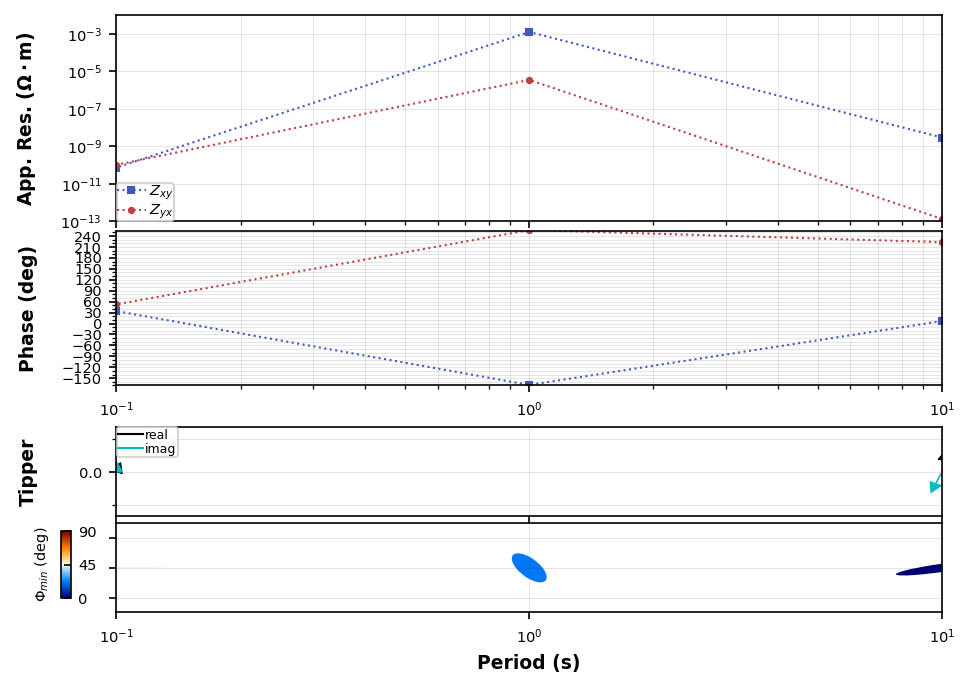

In [80]:
try:
    mc.plot_mt_response("T17")
except:
    pass

24:11:20T20:45:53 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID T17. Suggest setting survey, otherwise returning the TF from survey Test.


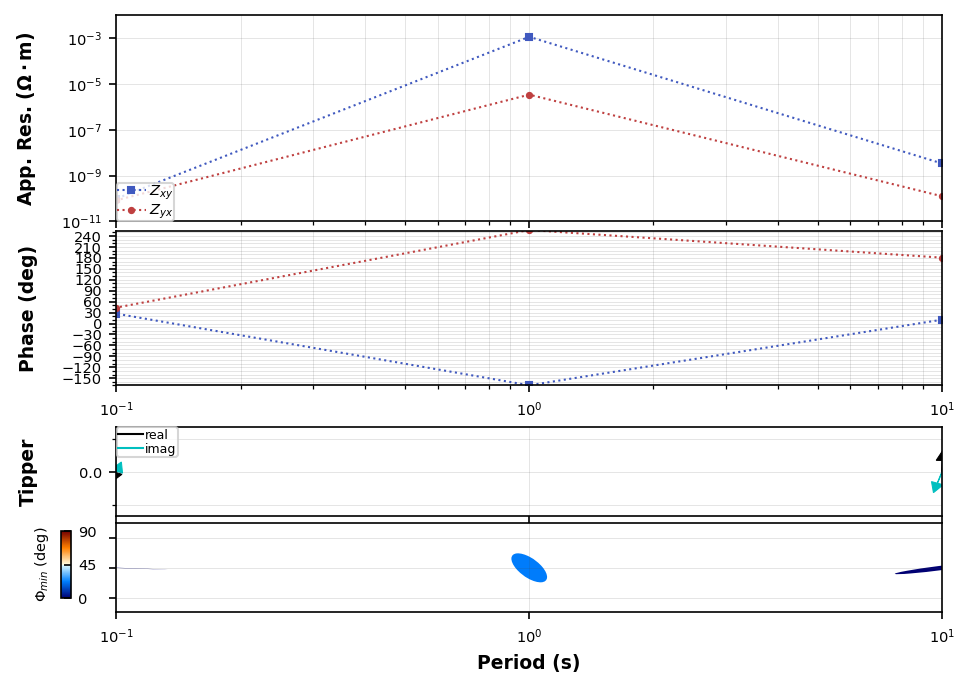

In [125]:
try:
    mc.plot_mt_response("T17")
except:
    pass

24:11:20T20:20:11 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


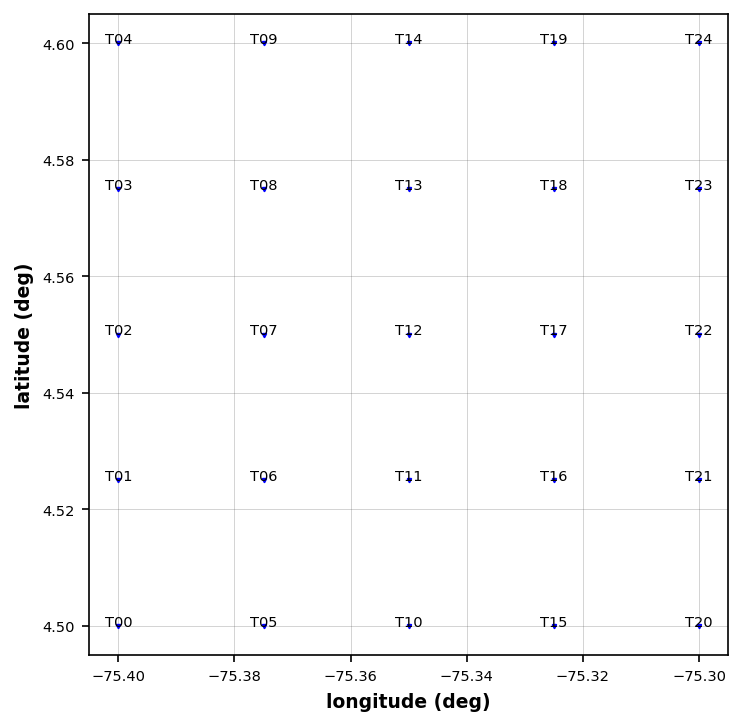

Plotting PlotStations

In [81]:
mc.plot_stations()

In [478]:
frequencies

array([1.00000000e+03, 4.83293024e+02, 2.33572147e+02, 1.12883789e+02,
       5.45559478e+01, 2.63665090e+01, 1.27427499e+01, 6.15848211e+00,
       2.97635144e+00, 1.43844989e+00, 6.95192796e-01, 3.35981829e-01,
       1.62377674e-01, 7.84759970e-02, 3.79269019e-02, 1.83298071e-02,
       8.85866790e-03, 4.28133240e-03, 2.06913808e-03, 1.00000000e-03])

24:11:01T17:17:17 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


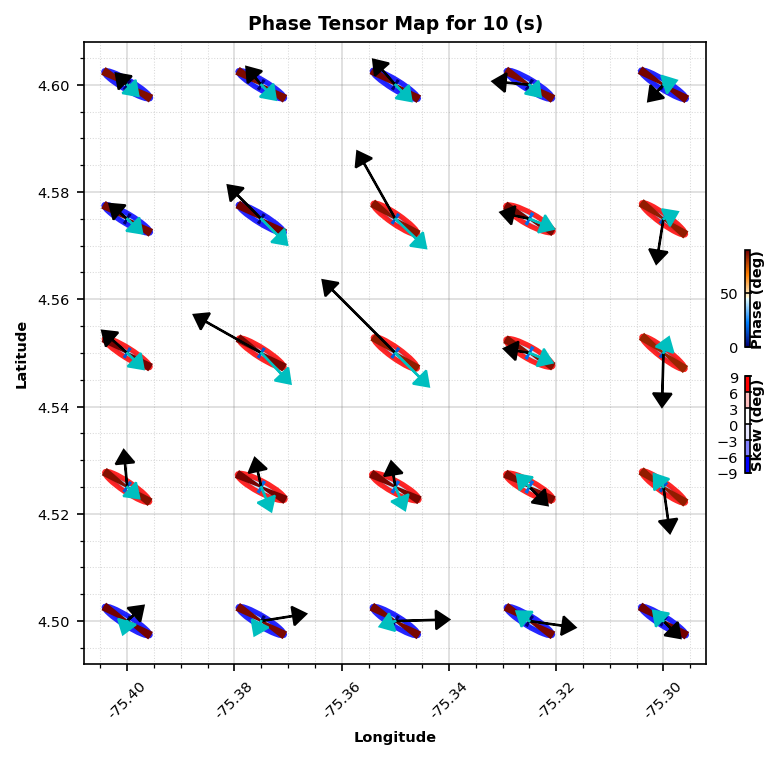

In [493]:
plot_pt_map = mc.plot_phase_tensor_map(
    plot_tipper="yri",
    arrow_size=0.06,
    #arrow_head_width=0.035,
    #arrow_head_length=0.025,
    arrow_lw=0.0001,
    x_pad=0.008,
    y_pad=0.008,
    plot_period = 10
)

24:11:01T17:19:32 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


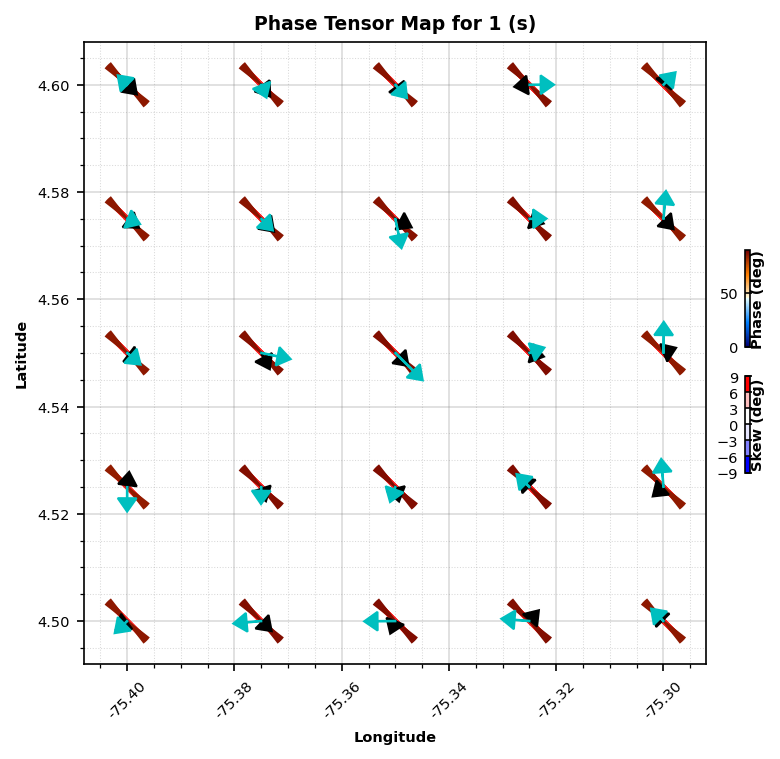

In [494]:
plot_pt_map.plot_period = 1
plot_pt_map.fig_num = 2
plot_pt_map.redraw_plot()

24:11:01T17:21:51 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


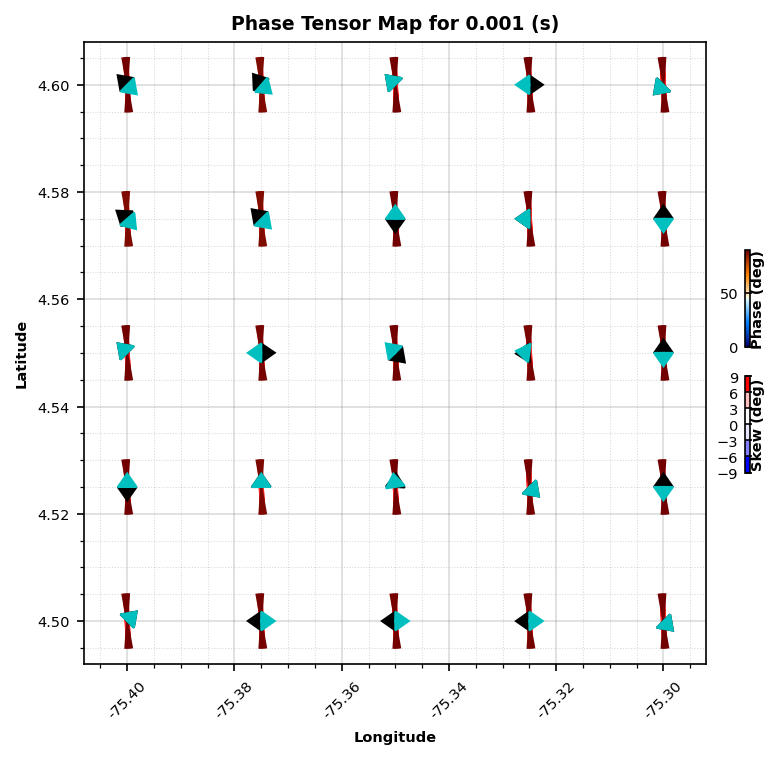

In [495]:
plot_pt_map.plot_period = 0.001
plot_pt_map.fig_num = 3
plot_pt_map.redraw_plot()

24:11:01T17:22:50 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


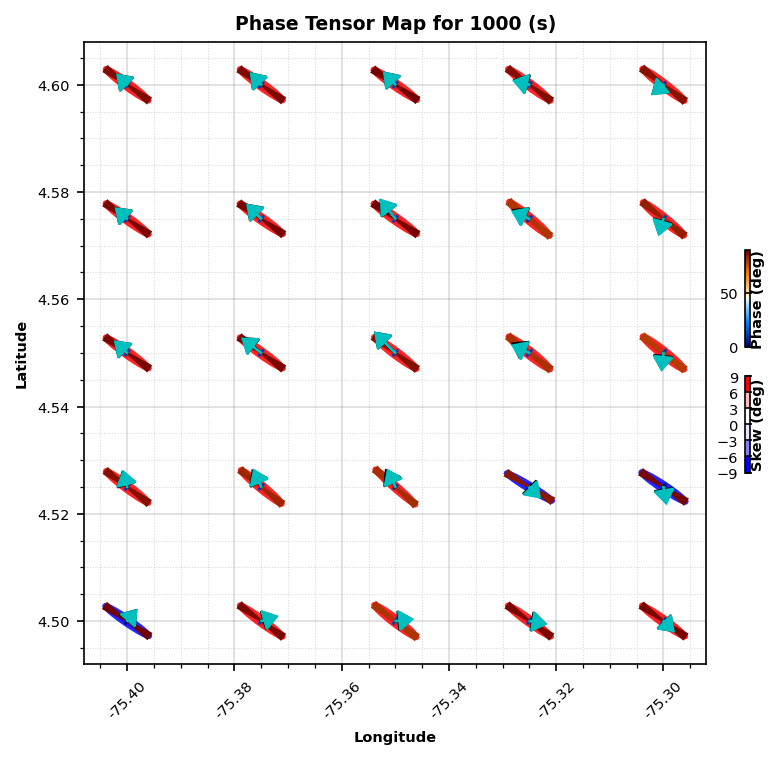

In [496]:
plot_pt_map.plot_period = 1000
plot_pt_map.fig_num = 4
plot_pt_map.redraw_plot()

24:11:01T17:23:09 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


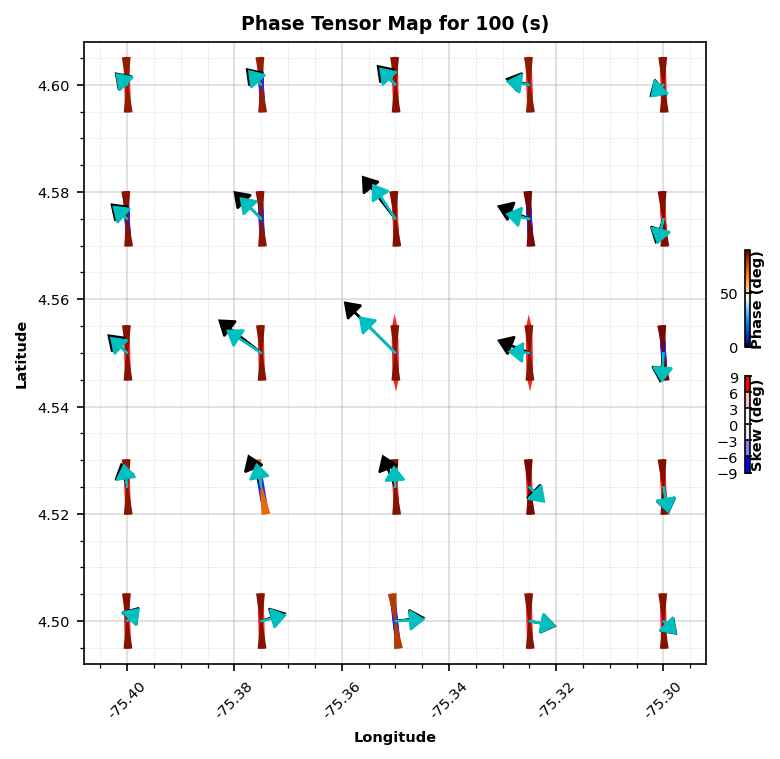

In [497]:
plot_pt_map.plot_period = 100
plot_pt_map.fig_num = 5
plot_pt_map.redraw_plot()

24:11:01T17:23:38 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


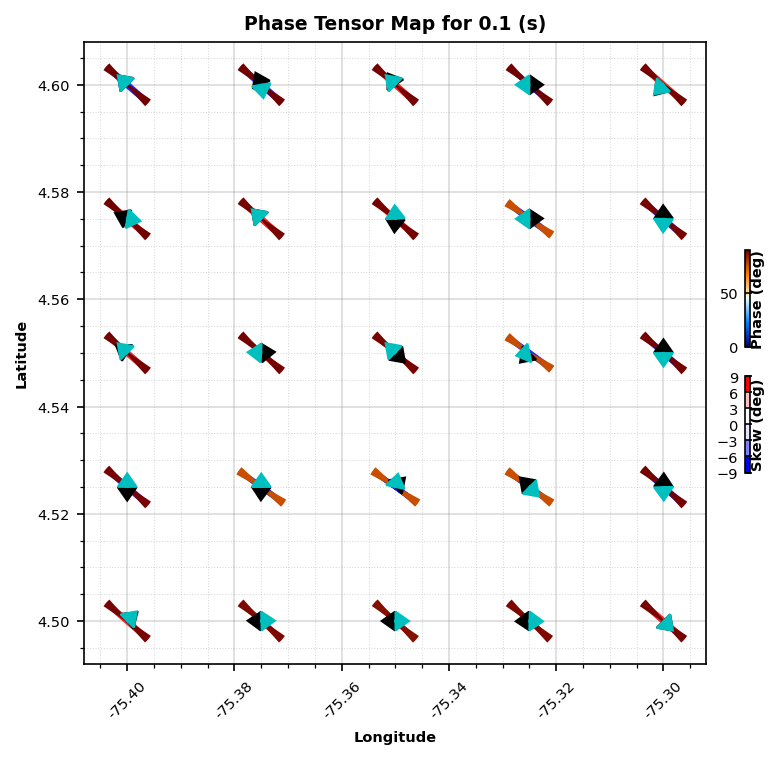

In [498]:
plot_pt_map.plot_period = 0.1
plot_pt_map.fig_num = 6
plot_pt_map.redraw_plot()

24:11:01T17:23:44 | WARNING | line:782 |mtpy.imaging.plot_phase_tensor_maps | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/13/3991/2380


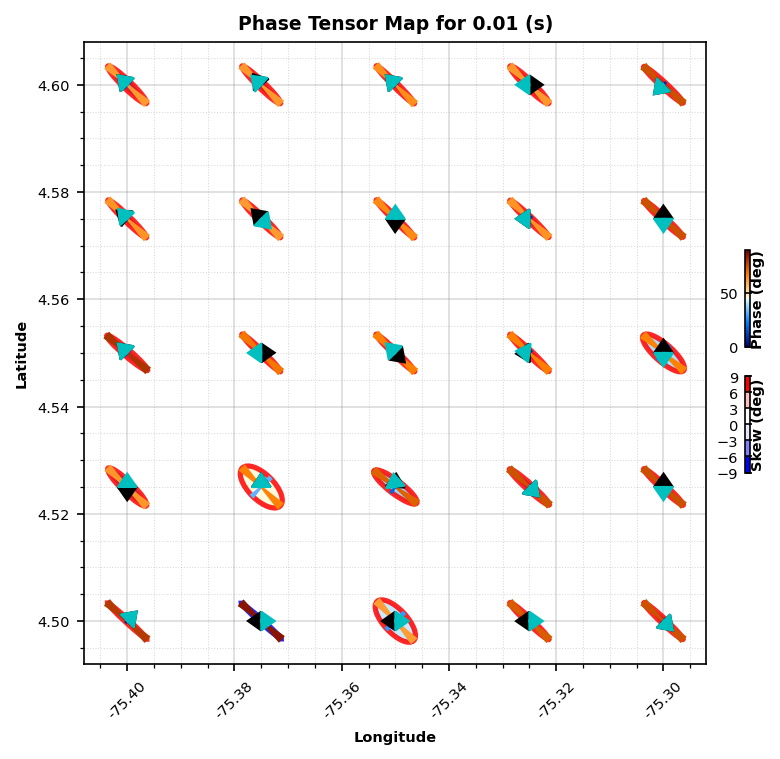

In [499]:
plot_pt_map.plot_period = 0.01
plot_pt_map.fig_num = 7
plot_pt_map.redraw_plot()

24:11:01T17:30:13 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID T17. Suggest setting survey, otherwise returning the TF from survey Test.


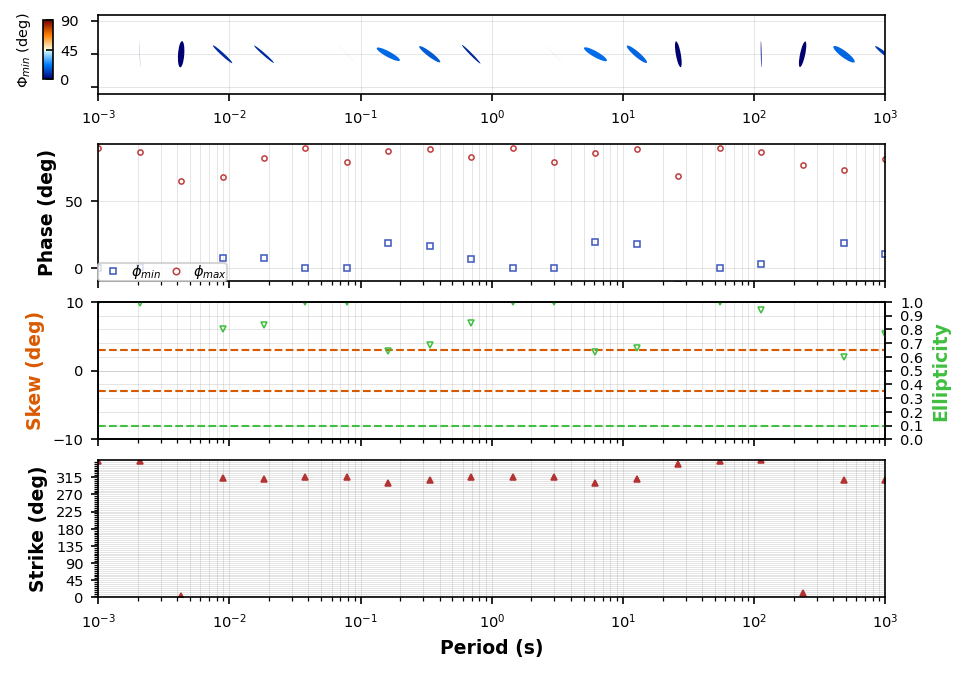

In [503]:
try:
    mc.plot_phase_tensor("T17")
except:
    pass

Plotting PlotResPhaseMaps

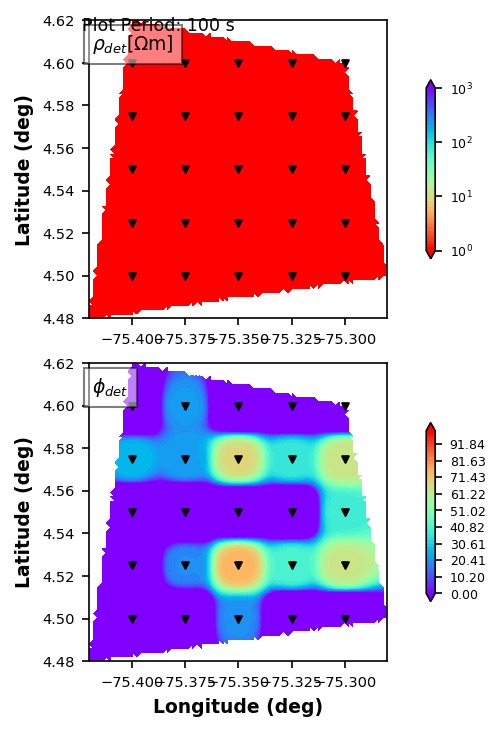

In [508]:
mc.plot_resistivity_phase_maps(
    plot_period = 100,
    plot_det = True,
    plot_xy = False,
    plot_yx = False
)

In [98]:
residuo = np.abs((DOBS.flatten()-DPRED.flatten())/DOBS.flatten())*100
error_relativo = np.round(residuo,2)

In [100]:
DOBS.shape

(3, 6, 2, 25)

In [101]:
DPRED.shape

(3, 6, 2, 25)

In [104]:
DOBS

array([[[[-5.87209440e-03, -6.15699141e-03, -6.04441919e-03,
          -6.17900427e-03, -6.30790086e-03, -3.18296822e-03,
          -1.65709684e-03, -3.79303870e-03, -5.61396492e-03,
          -6.10187261e-03, -2.31202089e-03, -9.76918611e-04,
          -2.90323047e-03, -4.99235982e-03, -5.59233661e-03,
          -3.16293917e-03, -1.54116297e-03, -1.77162648e-03,
          -2.17324498e-03, -4.24664909e-03, -5.82754454e-03,
          -5.94923937e-03, -5.89518355e-03, -5.99599808e-03,
          -5.96803819e-03],
         [-6.97285098e-03, -6.67038125e-03, -6.96310379e-03,
          -7.27985472e-03, -7.32325697e-03, -6.26043314e-03,
          -4.34087355e-03, -6.34818101e-03, -7.49535189e-03,
          -7.58288795e-03, -6.14492822e-03, -4.03881084e-03,
          -6.02651980e-03, -7.26883074e-03, -7.53461060e-03,
          -6.29125184e-03, -4.34846330e-03, -4.55684629e-03,
          -4.73218161e-03, -6.57882215e-03, -7.02345623e-03,
          -6.78703479e-03, -6.77682006e-03, -6.80032604e-

In [103]:
DPRED

array([[[[-5.77572977e-03, -5.92849948e-03, -5.96591947e-03,
          -6.23614108e-03, -6.42060786e-03, -3.21861262e-03,
          -2.02022759e-03, -4.00818880e-03, -5.75038098e-03,
          -6.18985280e-03, -2.31400889e-03, -9.44533337e-04,
          -2.76348703e-03, -4.85046801e-03, -5.55327242e-03,
          -3.16829903e-03, -1.65612496e-03, -1.53769107e-03,
          -2.25661166e-03, -4.16222158e-03, -5.64419854e-03,
          -5.42449825e-03, -5.27344649e-03, -5.46764093e-03,
          -5.83212067e-03],
         [-6.92184276e-03, -6.47511106e-03, -6.85700564e-03,
          -7.31233670e-03, -7.38423140e-03, -6.17261139e-03,
          -4.42436590e-03, -6.34176429e-03, -7.47771713e-03,
          -7.57317455e-03, -5.98469545e-03, -4.00070112e-03,
          -5.77241429e-03, -6.91889670e-03, -7.45462002e-03,
          -6.21695986e-03, -4.31655668e-03, -4.35824904e-03,
          -4.65472104e-03, -6.61085914e-03, -6.97991503e-03,
          -6.40154793e-03, -6.40912230e-03, -6.48863623e-

In [99]:
error_relativo

array([1.64000000e+00, 3.71000000e+00, 1.30000000e+00, 9.20000000e-01,
       1.79000000e+00, 1.12000000e+00, 2.19100000e+01, 5.67000000e+00,
       2.43000000e+00, 1.44000000e+00, 9.00000000e-02, 3.32000000e+00,
       4.81000000e+00, 2.84000000e+00, 7.00000000e-01, 1.70000000e-01,
       7.46000000e+00, 1.32000000e+01, 3.84000000e+00, 1.99000000e+00,
       3.15000000e+00, 8.82000000e+00, 1.05500000e+01, 8.81000000e+00,
       2.28000000e+00, 7.30000000e-01, 2.93000000e+00, 1.52000000e+00,
       4.50000000e-01, 8.30000000e-01, 1.40000000e+00, 1.92000000e+00,
       1.00000000e-01, 2.40000000e-01, 1.30000000e-01, 2.61000000e+00,
       9.40000000e-01, 4.22000000e+00, 4.81000000e+00, 1.06000000e+00,
       1.18000000e+00, 7.30000000e-01, 4.36000000e+00, 1.64000000e+00,
       4.90000000e-01, 6.20000000e-01, 5.68000000e+00, 5.43000000e+00,
       4.58000000e+00, 1.14000000e+00, 3.92000000e+00, 2.31000000e+00,
       2.84000000e+00, 1.43000000e+00, 2.27000000e+00, 8.57000000e+00,
      

In [173]:
mc.close_collection()

24:11:20T21:12:27 | INFO | line:761 |mth5.mth5 | close_mth5 | Flushing and closing collection_test_dpred.h5
